In [1]:
import pandas as pd
import matplotlib.pyplot  as plt
from jqdatasdk import *
import numpy as np
import talib as tl #技术指标
import datetime as dt
auth('15652961415','715905Si')
#sns.set_style('darkgrid')
plt.rcParams['font.sans-serif']=['SimHei']
path_base = 'C:/wangxiaolei/quant/Rong360-master/hongguan/'
#-*- coding: utf-8 -*-

auth success 


In [2]:
def show_index_hs(df_index, df_hs, label):
    fig = plt.figure(figsize=(15,6))
    x_index = df_hs.index
    ax1 = fig.add_subplot(111)
    ax1.plot(df_index,color = 'black', linewidth=2, label=label)
    ax1.legend(loc=2,fontsize=12)
    ax2=ax1.twinx()#这是双坐标关键一步
    ax2.plot(df_hs['close'], color = 'red',linewidth=2,label='沪深300指数')
    ax2.legend(loc=1,fontsize=12)
    # ax1.grid(False)
    ax2.grid(False)
    plt.show()
def show_benifit(df, label):
    x_index = df.index
    plt.figure(figsize=(12,6))
    plt.plot(x_index, df['benchmark'], color='black', label='benchmark')
    plt.plot(x_index, df['net_value'], color='red', label='net_value')
    plt.axhline(0,ls='--')
    plt.title(label)
    plt.xlabel('日期')
    plt.ylabel('收益')
    plt.legend()
rate_riskfree = 0.0 #无风险收益

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  


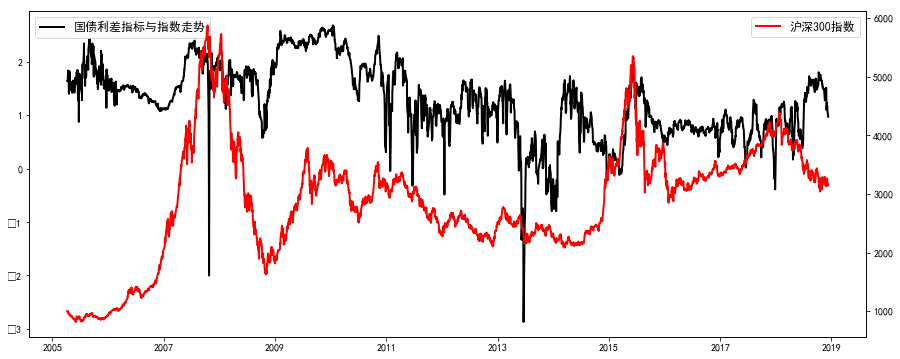

In [32]:
#获取国债期限利差数据
gz_path = path_base + '/guozhai.xls'
df_gz_spread = pd.read_excel(gz_path, sheet_name= [0])[0]
df_gz_spread.set_index('日期',inplace=True)
df_gz_spread = df_gz_spread.fillna(method='ffill')
df_hs =  get_price('000300.XSHG',start_date = df_gz_spread.index[0], end_date = df_gz_spread.index[-1],fields='close').dropna()
df_gz_spread = df_gz_spread.reindex(df_hs.index)
df_hs_M = df_hs.resample('M',how='last')
df_gz_spread['term_spread_10_1'] = df_gz_spread['中债国债到期收益率:10年'] - df_gz_spread['中债国债到期收益率:1个月']
show_index_hs(df_gz_spread['term_spread_10_1'], df_hs, '国债利差指标与指数走势')

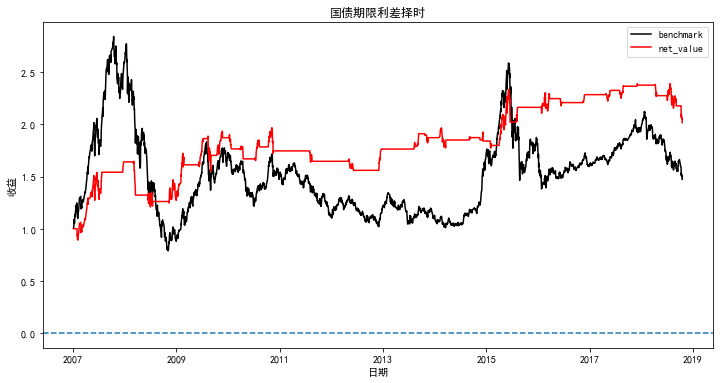

In [36]:
upperband, middleband, lowerband = (tl.BBANDS(df_gz_spread['term_spread_10_1'].values, timeperiod=25, nbdevup=1.8, nbdevdn=1.8))
df_gz_spread['BBAND_upper'] = upperband
df_gz_spread['BBAND_middle'] = middleband
df_gz_spread['BBAND_lower']=lowerband
signal = 0
for date in df_gz_spread.index:
    if df_gz_spread.loc[date,'term_spread_10_1'] < df_gz_spread.loc[date,'BBAND_middle']:
        df_gz_spread.loc[date,'signal'] = 0
    elif df_gz_spread.loc[date,'term_spread_10_1'] > df_gz_spread.loc[date,'BBAND_upper']:
        df_gz_spread.loc[date,'signal'] = 1.0
    else:
        df_gz_spread.loc[date,'signal'] = signal
    signal = df_gz_spread.loc[date, 'signal']

df_pct = pd.DataFrame()
df_pct = pd.concat([df_hs, df_gz_spread],axis=1)#['2007-01-01':'2018-11-30'].dropna()
df_pct['pct'] = df_pct['close'].pct_change()
df_pct['benchmark'] = (df_pct['pct'] + 1).cumprod()
df_pct['net_value'] = (df_pct['pct'] * df_pct['signal'].shift(1) + rate_riskfree * (1 - df_pct['signal'].shift(1)) + 1).cumprod()
show_benifit(df_pct,'国债期限利差择时')